In [16]:
#this code run on colab ref:  https://keras.io/api/applications/ , https://www.kaggle.com/code/harshpriye/dogs-breed-prediction-cnn-inceptionv3
!pip install openpyxl
import openpyxl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout ,GlobalAveragePooling2D,Rescaling, Input , BatchNormalization,AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.backend import clear_session

from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.xception import Xception
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
train_dir="/content/drive/MyDrive/archive/train"
valid_dir="/content/drive/MyDrive/archive/valid"

In [38]:
!cp "/content/drive/MyDrive/test_data.xlsx" "./"

In [3]:
#for convert data as input rescale and shuffle is important here
data_gen = ImageDataGenerator(rescale=1/255)
train_data = data_gen.flow_from_directory(batch_size=32, directory=train_dir, shuffle=True,target_size=(224,224), class_mode='categorical')

val_data = data_gen.flow_from_directory(batch_size=32, directory=valid_dir, shuffle=True,target_size=(224,224), class_mode='categorical')

Found 7955 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [20]:
#for later map to answer
label_sol_set=np.asarray(list(train_data.class_indices.keys()))

In [4]:
dog_data=pd.read_csv("/content/drive/MyDrive/archive/dogs.csv")

In [43]:
#examine training data, don't observe unbalanced problem
trset_num=len(dog_data.loc[dog_data["data set"]=="train"])

for i in range(0,len(list(train_data.class_indices.keys()))):
  a=len(dog_data.loc[dog_data["data set"]=="train"].loc[dog_data["labels"]==list(train_data.class_indices.keys())[i]])/trset_num
  b=list(train_data.class_indices.keys())[i]+" : "+str(a)

  print(b)

Afghan : 0.01321419582179713
African Wild Dog : 0.013717593757865593
Airedale : 0.014724389630002516
American Hairless : 0.00818021646111251
American Spaniel : 0.011200604077523282
Basenji : 0.012459098917694438
Basset : 0.02001006795872137
Beagle : 0.01547948653410521
Bearded Collie : 0.009942109237352127
Bermaise : 0.016486282406242135
Bichon Frise : 0.01321419582179713
Blenheim : 0.014220991693934055
Bloodhound : 0.018499874150515985
Bluetick : 0.01346589478983136
Border Collie : 0.01409514220991694
Borzoi : 0.013843443241882709
Boston Terrier : 0.009942109237352127
Boxer : 0.01686383085829348
Bull Mastiff : 0.01610873395419079
Bull Terrier : 0.012710797885728669
Bulldog : 0.015731185502139443
Cairn : 0.013969292725899824
Chihuahua : 0.013591744273848478
Chinese Crested : 0.014850239114019632
Chow : 0.013843443241882709
Clumber : 0.01522778756607098
Cockapoo : 0.016234583438207904
Cocker : 0.01636043292222502
Collie : 0.01434684117795117
Corgi : 0.014220991693934055
Coyote : 0.01044

In [ ]:
trset_num

7946

In [44]:
#examine validation data, don't observe unbalanced problem
vdset_num=len(dog_data.loc[dog_data["data set"]=="valid"])

for i in range(0,len(list(train_data.class_indices.keys()))):
  a=len(dog_data.loc[dog_data["data set"]=="valid"].loc[dog_data["labels"]==list(train_data.class_indices.keys())[i]])/vdset_num
  b=list(train_data.class_indices.keys())[i]+" : "+str(a)

  print(b)

Afghan : 0.014285714285714285
African Wild Dog : 0.014285714285714285
Airedale : 0.014285714285714285
American Hairless : 0.014285714285714285
American Spaniel : 0.0
Basenji : 0.014285714285714285
Basset : 0.014285714285714285
Beagle : 0.014285714285714285
Bearded Collie : 0.014285714285714285
Bermaise : 0.014285714285714285
Bichon Frise : 0.014285714285714285
Blenheim : 0.014285714285714285
Bloodhound : 0.014285714285714285
Bluetick : 0.014285714285714285
Border Collie : 0.014285714285714285
Borzoi : 0.014285714285714285
Boston Terrier : 0.014285714285714285
Boxer : 0.014285714285714285
Bull Mastiff : 0.014285714285714285
Bull Terrier : 0.014285714285714285
Bulldog : 0.014285714285714285
Cairn : 0.014285714285714285
Chihuahua : 0.014285714285714285
Chinese Crested : 0.014285714285714285
Chow : 0.014285714285714285
Clumber : 0.014285714285714285
Cockapoo : 0.014285714285714285
Cocker : 0.014285714285714285
Collie : 0.014285714285714285
Corgi : 0.014285714285714285
Coyote : 0.0142857142

In [5]:
#define function for monitor loss to reduce learn rate and early stop for training
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)

In [6]:
IMG_SHAPE = (224,224,3)
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)

87910968/87910968 [==============================] - 1s 0us/step


In [7]:
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(100,activation='relu'))
model.add(Dense(70,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 70)                7070      
                                                                 
Total params: 22014754 (83.98 MB)
Trainable params: 211970 (828.01 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


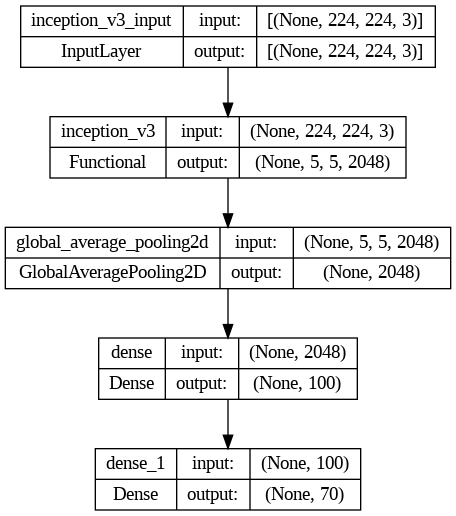

In [8]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=False,dpi=96)

In [9]:
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)

In [ ]:
logs = model.fit(train_data, validation_data=val_data,epochs=80, verbose=1, callbacks=[reduce_lr,es])
model.save('IcpV3_model.keras')
!cp "/content/IcpV3_model.keras" "/content/drive/MyDrive"
mpdel_inform_list=[logs.history['accuracy'],logs.history['val_accuracy'],logs.history['loss'],logs.history['val_loss']]

Epoch 1/80
249/249 [==============================] - 3674s 15s/step - loss: 0.9923 - accuracy: 0.7656 - val_loss: 0.7636 - val_accuracy: 0.8886 - lr: 0.0100
Epoch 2/80
249/249 [==============================] - 41s 164ms/step - loss: 0.6056 - accuracy: 0.8375 - val_loss: 0.8487 - val_accuracy: 0.8543 - lr: 0.0100
Epoch 3/80
249/249 [==============================] - 41s 166ms/step - loss: 0.5480 - accuracy: 0.8573 - val_loss: 0.7279 - val_accuracy: 0.8729 - lr: 0.0100
Epoch 4/80
249/249 [==============================] - 42s 167ms/step - loss: 0.4735 - accuracy: 0.8729 - val_loss: 0.8293 - val_accuracy: 0.8900 - lr: 0.0100
Epoch 5/80
249/249 [==============================] - 42s 169ms/step - loss: 0.4462 - accuracy: 0.8811 - val_loss: 1.2123 - val_accuracy: 0.8786 - lr: 0.0100
Epoch 6/80
249/249 [==============================] - 41s 166ms/step - loss: 0.4724 - accuracy: 0.8805 - val_loss: 0.8274 - val_accuracy: 0.9029 - lr: 0.0100
Epoch 7/80
249/249 [==============================] 

In [ ]:
np.save("IcPV3_model.npy",mpdel_inform_list)

In [ ]:
!cp "/content/IcPV3_model.npy" "/content/drive/MyDrive"

In [ ]:
logs.history

{'loss': [0.9922813177108765,
  0.6055881381034851,
  0.5480192303657532,
  0.4735146462917328,
  0.44624942541122437,
  0.4724161624908447,
  0.4429480731487274,
  0.41173863410949707,
  0.4317919611930847,
  0.45166870951652527,
  0.4171712100505829,
  0.43930354714393616,
  0.41475710272789,
  0.2954123020172119,
  0.27873867750167847,
  0.26507997512817383,
  0.25346142053604126,
  0.24355559051036835,
  0.23483897745609283,
  0.2270902544260025,
  0.2202845960855484,
  0.21418672800064087,
  0.2086644172668457,
  0.20356379449367523,
  0.19879259169101715,
  0.19444239139556885,
  0.1905139684677124,
  0.18692581355571747,
  0.18362411856651306,
  0.18062852323055267,
  0.1778048276901245,
  0.17516882717609406,
  0.17254962027072906,
  0.17004993557929993,
  0.16758380830287933,
  0.16527409851551056,
  0.16316081583499908,
  0.1611412614583969,
  0.15929771959781647,
  0.15753081440925598,
  0.15584805607795715,
  0.15426023304462433,
  0.15265777707099915,
  0.15113507211208344

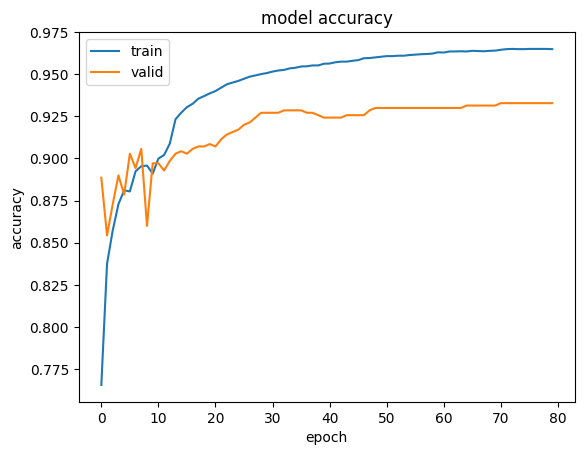

In [ ]:
plt.plot(logs.history['accuracy'])
plt.plot(logs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

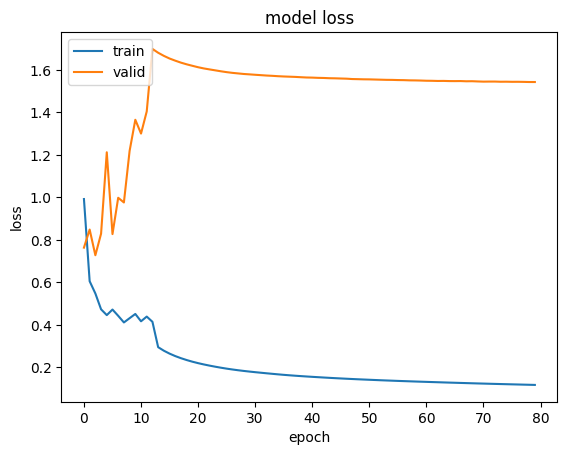

In [ ]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [11]:
#load trained model(for colab limit resource)
lcpV3_based_model=keras.saving.load_model("/content/drive/MyDrive/IcpV3_model.keras")

In [12]:
# read fig name in testing set folder
import os
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("/content/drive/MyDrive/Testing set") if isfile(join("/content/drive/MyDrive/Testing set", f))]

In [32]:
#return prediction result and correspond file name for each picture
def image_turn_to_arr_to_predict(pname,filname,given_model,solution_set):
  workin_name=pname+filname
  pic_o=Image.open(workin_name)
  pic_o=pic_o.resize((224,224))
  pic_arr=tf.keras.utils.img_to_array(pic_o)
  pic_arr=pic_arr/255.0
  pic_arr=np.expand_dims(pic_arr,0)
  an_s=given_model.predict(pic_arr)
  idx=an_s.argmax()
  pic_o.close()
  return [solution_set[idx], filname]

In [35]:
tr_ans_list=[]
only_ans_list=[]

for i in range(0,len(onlyfiles)):
  try_answer=image_turn_to_arr_to_predict("/content/drive/MyDrive/Testing set/",onlyfiles[i],lcpV3_based_model,label_sol_set)
  tr_ans_list.append(try_answer)
  only_ans_list.append(try_answer[0])

1/1 [==============================] - 0s 165ms/step


In [42]:
#write result in xlsx
wb=openpyxl.load_workbook('test_data.xlsx', data_only=True)

s1 = wb['Sheet1']
for i in range(0,len(tr_ans_list)):
  s1.cell(i+2,1).value=tr_ans_list[i][1]
  s1.cell(i+2,2).value=tr_ans_list[i][0]
wb.save('test2.xlsx')